In [9]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
Image.MAX_IMAGE_PIXELS = 933120000
filename = "NDWI_Mask_130_resized.tif"
image_path = "./GEE_Masks/GEE_resized/"

# Erosion


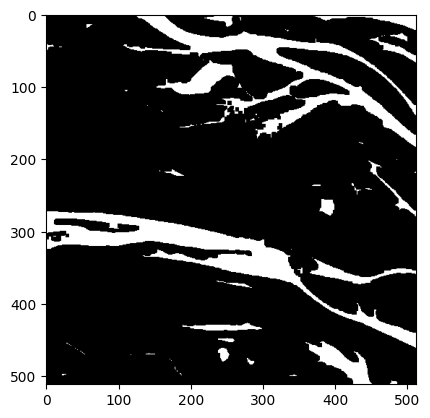

In [2]:
img = cv.imread(image_path+filename, cv.IMREAD_GRAYSCALE)
assert img is not None, "file could not be read, check with os.path.exists()"
kernel = np.ones((5,5),np.uint8)
erosion = cv.erode(img,kernel,iterations = 1)
plt.imshow(erosion,cmap='gray')
plt.show()

In [10]:
img = Image.open(image_path+filename)

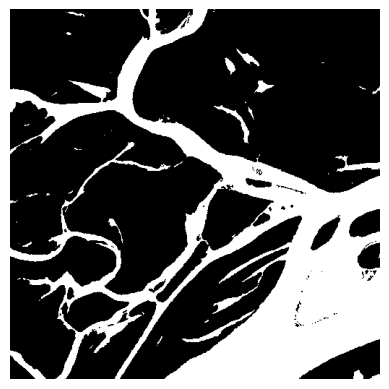

In [11]:
# Convert the image to numpy array
img_array = np.array(img)

# Plot the image
plt.imshow(img_array, cmap='gray')  # You can change the colormap as per your need
plt.axis('off')  # Turn off axis
plt.show()

# Dialation

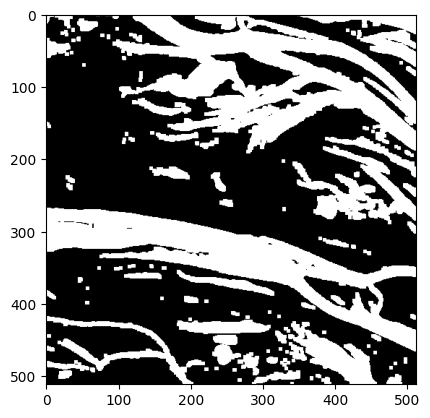

In [5]:
img = cv.imread(image_path+filename, cv.IMREAD_GRAYSCALE)
assert img is not None, "file could not be read, check with os.path.exists()"
kernel = np.ones((5,5),np.uint8)
dilation = cv.dilate(img,kernel,iterations = 1)
plt.imshow(dilation,cmap='gray')
plt.show()

In [2]:
import os
import cv2 as cv
import numpy as np
import random
import shutil


# Define the source directory
source_dir = './GEE_Masks/GEE_resized/train_gee'

# Function to calculate the number of pixels changed by erosion
def count_changed_pixels(original, eroded):
    return np.sum(original != eroded)

# Kernel for erosion
kernel = np.ones((5, 5), np.uint8)

def apply_erosion_with_threshold(img, target_changes, threshold=10):
    eroded_img = img.copy()
    total_changed = 0
    iterations = 0
    while abs(total_changed - target_changes) > threshold:
        eroded_img = cv.erode(eroded_img, kernel, iterations=1)
        total_changed = count_changed_pixels(img, eroded_img)
        iterations += 1
        if iterations > 100:  # Prevent infinite loop
            break
    return eroded_img, total_changed

# Function to apply dilation with stopping criteria based on the number of pixel changes
def apply_dilation_with_threshold(img, target_changes, threshold=10):
    dilated_img = img.copy()
    total_changed = 0
    iterations = 0
    while abs(total_changed - target_changes) > threshold:
        dilated_img = cv.dilate(dilated_img, kernel, iterations=1)
        total_changed = count_changed_pixels(img, dilated_img)
        iterations += 1
        if iterations > 100:  # Prevent infinite loop
            break
    return dilated_img, total_changed


In [3]:
all_files = [f for f in os.listdir(source_dir) if f.endswith('_resized.tif')]

# Shuffle the list to ensure randomness
random.shuffle(all_files)

# Split the files into three sets
split_index_1 = len(all_files) // 3
split_index_2 = 2 * len(all_files) // 3

set_1 = all_files[:split_index_1]      # First group for erosion
set_2 = all_files[split_index_1:split_index_2]  # Second group for dilation
set_3 = all_files[split_index_2:]      # Third group to be left unchanged

In [14]:
# first_img_path = os.path.join(source_dir, set_1[0])
# first_img = cv.imread(first_img_path, cv.IMREAD_GRAYSCALE)
# assert first_img is not None, f"File {set_1[0]} could not be read"

# # Apply erosion and calculate the number of changed pixels for the first image in set_1
# first_erosion = cv.erode(first_img, kernel, iterations=1)
# num_changed_pixels_erosion = count_changed_pixels(first_img, first_erosion)

# # Determine the number of pixels to corrupt from the first image in set_2
# first_img_path = os.path.join(source_dir, set_2[0])
# first_img = cv.imread(first_img_path, cv.IMREAD_GRAYSCALE)
# assert first_img is not None, f"File {set_2[0]} could not be read"

# # Apply dilation and calculate the number of changed pixels for the first image in set_2
# first_dilation = cv.dilate(first_img, kernel, iterations=1)
# num_changed_pixels_dilation = count_changed_pixels(first_img, first_dilation)

In [4]:
def average_corrupted_pixels(source_dir, set_1, set_2, kernel):
    # Initialize variables to accumulate the sum of corrupted pixels
    total_changed_pixels_erosion = 0
    total_changed_pixels_dilation = 0

    # Loop through all images in set_1
    for img_name in set_1:
        img_path = os.path.join(source_dir, img_name)
        img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
        assert img is not None, f"File {img_name} could not be read"

        # Apply erosion and count changed pixels
        eroded_img = cv.erode(img, kernel, iterations=1)
        num_changed_pixels = count_changed_pixels(img, eroded_img)
        total_changed_pixels_erosion += num_changed_pixels

    # Loop through all images in set_2
    for img_name in set_2:
        img_path = os.path.join(source_dir, img_name)
        img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
        assert img is not None, f"File {img_name} could not be read"

        # Apply dilation and count changed pixels
        dilated_img = cv.dilate(img, kernel, iterations=1)
        num_changed_pixels = count_changed_pixels(img, dilated_img)
        total_changed_pixels_dilation += num_changed_pixels

    # Calculate the average number of corrupted pixels
    avg_changed_pixels_erosion = total_changed_pixels_erosion / len(set_1)
    avg_changed_pixels_dilation = total_changed_pixels_dilation / len(set_2)

    return avg_changed_pixels_erosion, avg_changed_pixels_dilation

# kernel = cv.getStructuringElement(cv.MORPH_RECT, (3, 3))  # Example kernel

avg_erosion, avg_dilation = average_corrupted_pixels(source_dir, set_1, set_2, kernel)

In [5]:
for file_name in set_1:
    img = cv.imread(os.path.join(source_dir, file_name), cv.IMREAD_GRAYSCALE)
    assert img is not None, f"File {file_name} could not be read"

    # Apply erosion with the target number of pixel changes
    erosion, changed_pixels = apply_erosion_with_threshold(img, avg_erosion)

    # Save the eroded image with the new filename in the same directory
    new_filename = file_name.replace('_resized.tif', '_resized1_corrupt.tif')
    cv.imwrite(os.path.join(source_dir, new_filename), erosion)

    print(f'{file_name} (Erosion): {changed_pixels} pixels changed')

# Apply dilation to the second group
for file_name in set_2:
    img = cv.imread(os.path.join(source_dir, file_name), cv.IMREAD_GRAYSCALE)
    assert img is not None, f"File {file_name} could not be read"

    # Apply dilation with the target number of pixel changes
    dilation, changed_pixels = apply_dilation_with_threshold(img, avg_dilation)

    # Save the dilated image with the new filename in the same directory
    new_filename = file_name.replace('_resized.tif', '_resized1_corrupt.tif')
    cv.imwrite(os.path.join(source_dir, new_filename), dilation)

    print(f'{file_name} (Dilation): {changed_pixels} pixels changed')

# Copy the third group without modification
for file_name in set_3:
    src_path = os.path.join(source_dir, file_name)
    dest_path = os.path.join(source_dir, file_name.replace('_resized.tif', '_resized_corrupt1.tif'))
    shutil.copy(src_path, dest_path)
    print(f'{file_name} copied to {dest_path}')

print('Processing completed.')

NDWI_Mask_1063_resized.tif (Erosion): 95122 pixels changed
NDWI_Mask_54_resized.tif (Erosion): 49553 pixels changed
NDWI_Mask_203_resized.tif (Erosion): 201143 pixels changed
NDWI_Mask_814_resized.tif (Erosion): 50337 pixels changed
NDWI_Mask_966_resized.tif (Erosion): 132939 pixels changed
NDWI_Mask_968_resized.tif (Erosion): 10043 pixels changed
NDWI_Mask_226_resized.tif (Erosion): 183987 pixels changed
NDWI_Mask_93_resized.tif (Erosion): 0 pixels changed
NDWI_Mask_1210_resized.tif (Erosion): 2 pixels changed
NDWI_Mask_707_resized.tif (Erosion): 78312 pixels changed
NDWI_Mask_923_resized.tif (Erosion): 79001 pixels changed
NDWI_Mask_1141_resized.tif (Erosion): 786 pixels changed
NDWI_Mask_660_resized.tif (Erosion): 3237 pixels changed
NDWI_Mask_406_resized.tif (Erosion): 44579 pixels changed
NDWI_Mask_428_resized.tif (Erosion): 0 pixels changed
NDWI_Mask_534_resized.tif (Erosion): 2802 pixels changed
NDWI_Mask_661_resized.tif (Erosion): 251 pixels changed
NDWI_Mask_702_resized.tif (E